In [31]:
import numpy as np
import pandas as pd

from jax import numpy as jnp
from jax import random as jr
from jax import vmap
from matplotlib import pyplot as plt

# !pip install dynamax
from dynamax.utils.plotting import plot_uncertainty_ellipses
from dynamax.linear_gaussian_ssm import LinearGaussianSSM
from dynamax.linear_gaussian_ssm import lgssm_smoother, lgssm_filter
import optax

In [32]:
def simulate_data(start_date, end_date, gradients, noise_std, frequency):

    #We will split the periods up evenly into the nuber of different gradients we have passed
    number_of_periods = len(gradients)

    date_range = pd.date_range(start_date, end_date,freq=frequency)
    group_len = len(date_range)//number_of_periods
    group_remainder = len(date_range)%number_of_periods

    signal = []
    for period in range(number_of_periods):
        #If we are on the last group we have to add extra x values if the number of periods doesn't divide the length of the date range exactly
        if (period + 1) == number_of_periods:
            x_values = np.arange(0,group_len+group_remainder)
        else:
            x_values = np.arange(0,group_len)

        #Set the y values to be the gradient * x_values with the last y value from the last period added on
        if len(signal) > 0:
            y_values = gradients[period] * x_values + y_values[-1]
        else:
            y_values = gradients[period] * x_values

        signal.extend(y_values)

    #We now want to add noise to the observations
    signal = signal + np.random.normal(0, noise_std, size=len(signal))

    print(len(date_range),len(signal))

    #Conscruct data frame
    simulated_data = pd.DataFrame({'TIMESTAMP':date_range,'SIGNAL':signal,'ASSET_NUMBER':'N/A'})

    return simulated_data

1297 1297


<Axes: xlabel='TIMESTAMP'>

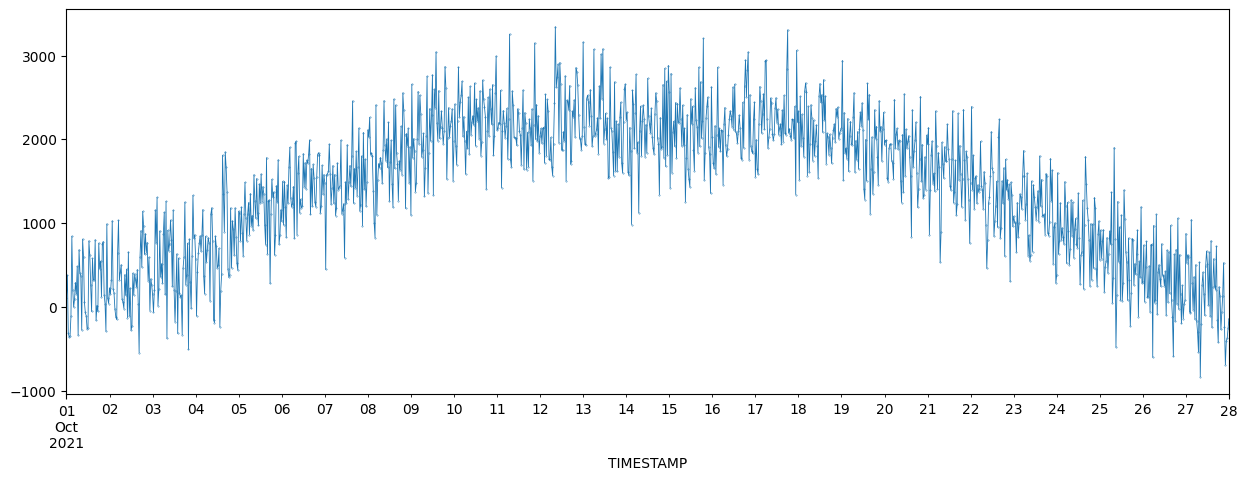

In [33]:
gradients = [5,0,-5]
start_date = '2021-10-01 00:00:00'
end_date = '2021-10-28 00:00:00'
frequency = '30T'
noise_std = 400

simulated_data = simulate_data(start_date,
                                 end_date,
                                 gradients,
                                 noise_std,
                                 frequency)

simulated_data["TIMESTAMP"] = pd.to_datetime(simulated_data["TIMESTAMP"])
simulated_data = simulated_data.set_index("TIMESTAMP")["SIGNAL"]

simulated_data.plot(marker='.',
                    markersize=0.6,
                    linewidth=0.6,
                    figsize=(15,5))


## The State Space Model - Local Linear Trend Model

We are using notation from Time Series Analysis by State Space Methods - J.Durbin and S.J.Koopman.


$$y_t = \mu_t + \varepsilon_t,\ \ \ \ \ \ \ \ \ \ \ \ \ \ \varepsilon_t \sim N(0, \sigma^2_\varepsilon)$$

$$\mu_{t+1} = \mu_t + \nu_t + \xi_t,\ \ \xi_t \sim N(0, \sigma^2_\xi)$$

$$\nu_{t+1} = \nu_t + \zeta_t,\ \ \ \ \ \ \ \ \ \ \ \zeta_t \sim N(0, \sigma^2_\zeta) \ \ \ $$


The three components are often different across literature.  In order to align with the text:

* \\(y_t\\) is the observation
* \\(\mu_t\\) is the level
* \\(\nu_t\\) is the slope


This fits into the state space form as follows:

$$y_t = Z_t\alpha_t+\varepsilon_t,\ \ \ \ \ \ \ \ \ \ \ \ \ \varepsilon_t \sim N(0, H_t)$$

$$\alpha_{t+1} = T_t\alpha_t + R_t\eta_t,\ \ \ \ \ \eta_t \sim N(0,Q_t)$$


Where:

$$Z_t = \begin{bmatrix}
  1       & 0 \\
\\end{bmatrix}\$$


$$\alpha_t = \begin{bmatrix}
  \mu_t       \\
  \nu_t
\\end{bmatrix}\$$

$$H = \\sigma_\varepsilon ^2\$$

$$T_t = \\begin{bmatrix}
  1 & 1 \\\\
  0 & 1
\\end{bmatrix}\$$

$$R_t = \\begin{bmatrix}
  1 & 0 \\\\
  0 & 1
\\end{bmatrix}\$$


$$Q_t = \\begin{bmatrix}
    \sigma^2_\xi   &   0 \\\\
    0   &   \sigma^2_\zeta
\end{bmatrix}\$$

In [34]:
state_dim = 2
emission_dim = 1

# jax array
simulated_data_jnp = jnp.array(simulated_data.values)[:,None]

# Create object
lgssm = LinearGaussianSSM(state_dim, emission_dim)

# Manually chosen parameters
initial_mean = jnp.array([0.2, 1e-16])
initial_covariance = jnp.eye(state_dim) * 0.1
dynamics_weights  = jnp.array([[1.0, 1.0],
                               [0.0, 1.0]])
dynamics_covariance = jnp.eye(state_dim) * 0.0005
emission_weights = jnp.array([[1.0, 0.0]])
emission_covariance = jnp.eye(emission_dim) * 2000.0

# Initialize model
params, props = lgssm.initialize(jr.PRNGKey(0),
                             initial_mean=initial_mean,
                             initial_covariance=initial_covariance,
                             dynamics_weights=dynamics_weights,
                             dynamics_covariance=dynamics_covariance,
                             emission_weights=emission_weights,
                             emission_covariance=emission_covariance)

# smooth + filter using default parameters
lgssm_posterior = lgssm.smoother(params, simulated_data_jnp)


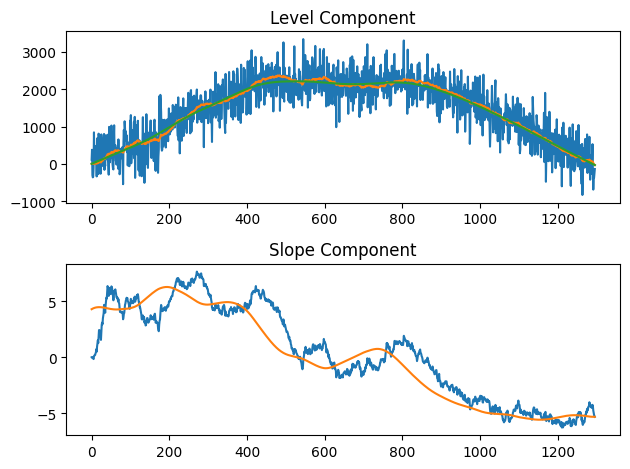

In [35]:
fig, axs = plt.subplots(nrows=2)

axs[0].plot(simulated_data.values)
axs[0].plot(lgssm_posterior.filtered_means[:,0])
axs[0].plot(lgssm_posterior.smoothed_means[:,0])
axs[0].set_title("Level Component")

axs[1].plot(lgssm_posterior.filtered_means[:,1])
axs[1].plot(lgssm_posterior.smoothed_means[:,1])
axs[1].set_title("Slope Component")

fig.tight_layout()

In [53]:
fit_params, train_output = lgssm.fit_sgd(params,
                                         props,
                                         simulated_data_jnp,
                                         optimizer=optax.adam(1e-5),
                                         batch_size=200,
                                         num_epochs=300)


# smooth + filter using fitted parameters
lgssm_posterior = lgssm.smoother(fit_params, simulated_data_jnp)

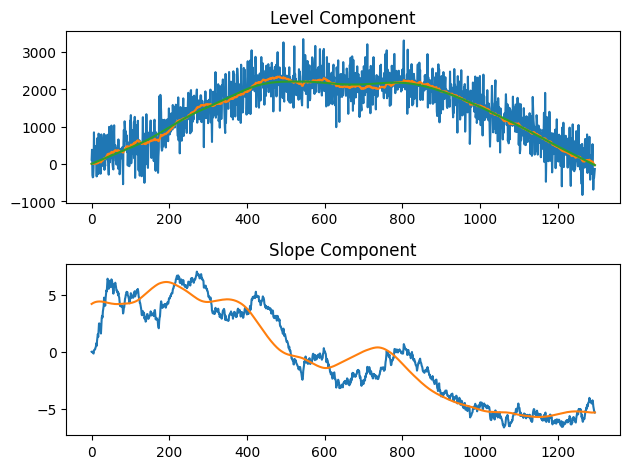

In [54]:
fig, axs = plt.subplots(nrows=2)

axs[0].plot(simulated_data.values)
axs[0].plot(lgssm_posterior.filtered_means[:,0])
axs[0].plot(lgssm_posterior.smoothed_means[:,0])
axs[0].set_title("Level Component")

axs[1].plot(lgssm_posterior.filtered_means[:,1])
axs[1].plot(lgssm_posterior.smoothed_means[:,1])
axs[1].set_title("Slope Component")

fig.tight_layout()

## NAN Values

In [11]:
simulated_data_nans = simulated_data.copy()
simulated_data_nans.iloc[10:20] = np.nan

# jax array
simulated_data_jnp = jnp.array(simulated_data_nans.values)[:,None]

In [15]:
fit_params, train_output = lgssm.fit_sgd(params, props, simulated_data_jnp)

# smooth + filter using fitted parameters
lgssm_posterior = lgssm.smoother(fit_params, simulated_data_jnp)

lgssm_posterior

PosteriorGSSMSmoothed(marginal_loglik=Array(nan, dtype=float32), filtered_means=Array([[nan, nan],
       [nan, nan],
       [nan, nan],
       ...,
       [nan, nan],
       [nan, nan],
       [nan, nan]], dtype=float32), filtered_covariances=Array([[[nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan, nan]],

       ...,

       [[nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan, nan]]], dtype=float32), smoothed_means=Array([[nan, nan],
       [nan, nan],
       [nan, nan],
       ...,
       [nan, nan],
       [nan, nan],
       [nan, nan]], dtype=float32), smoothed_covariances=Array([[[nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan, nan]],

       ...,

       [[nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan, nan]]], dtype=float32), smoothed_cross_